The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Importing Libraries and Loading Data

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

In [177]:
df=pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [178]:
# change the name of the column "Class" to "Fraud"
df.rename(columns={"Class":"Fraud"},inplace=True)

In [179]:
df["Time"]=df.Time/7200

In [4]:
df.shape

(284807, 31)

In [97]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Fraud     0
dtype: int64

In [108]:
print("Regular transactions: {}%".format(round((df.Fraud==0).sum()/len(df)*100,2)))
print("Fraudulent transactions: {}%".format(round((df.Fraud==1).sum()/len(df)*100,2)))

Regular transactions: 99.83%
Fraudulent transactions: 0.17%


<AxesSubplot:xlabel='Fraud', ylabel='count'>

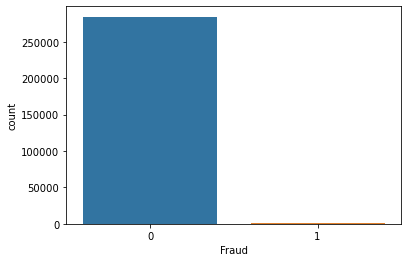

In [109]:
sns.countplot(df.Fraud)

In [91]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,1.316859e+01,6.595576,0.000000,7.527986,11.762778,19.350069,23.998889
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [133]:
# the variables are very skewed, containing a lot of outliers
pd.DataFrame([df.skew(),df.kurtosis()],index=["skew","kurtosis"]).T

,skew,kurtosis
Time,-0.035568,-1.293530
V1,-3.280667,32.486679
V2,-4.624866,95.773106
V3,-2.240155,26.619551
V4,0.676292,2.635455
V5,-2.425901,206.904560
V6,1.826581,42.642494
V7,2.553907,405.607417
V8,-8.521944,220.586974
V9,0.554680,3.731311


<AxesSubplot:xlabel='V28'>

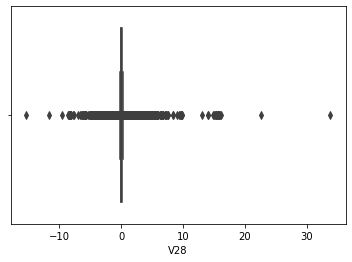

In [134]:
# example of a highly skewed variable
sns.boxplot(df.V28)

<AxesSubplot:xlabel='Time', ylabel='Count'>

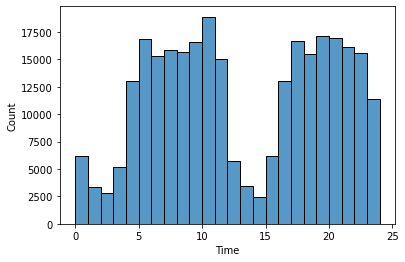

In [92]:
# using seaborn
sns.histplot(df.Time,bins=24)
# matplotlib
# plt.hist(df.Time,bins=24)
# plt.grid()

# pandas with matplotlib backend
# df.Time.hist(bins=24)

# plotly
# px.histogram(df.Time,nbins=24)

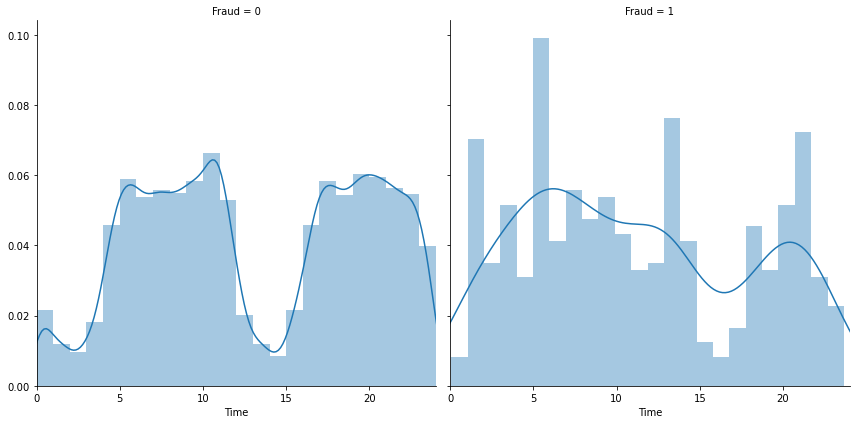

In [94]:
g=sns.FacetGrid(df, col = "Fraud",size=6)
g.map(sns.distplot, "Time", bins = 24)
g.set(xlim=(0,24))
plt.show()

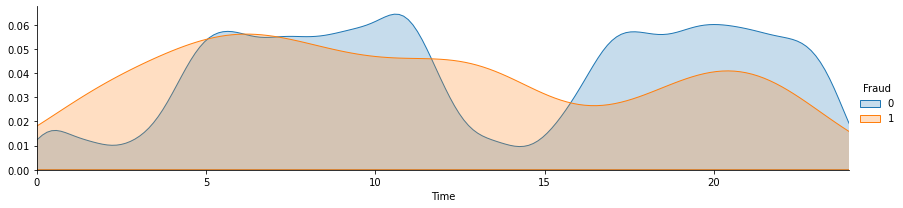

In [95]:
g=sns.FacetGrid(df,hue="Fraud",aspect=4)
g.map(sns.kdeplot,"Time",shade=True)
g.set(xlim = (0,df["Time"].max()))
g.add_legend()

<AxesSubplot:xlabel='Fraud', ylabel='Amount'>

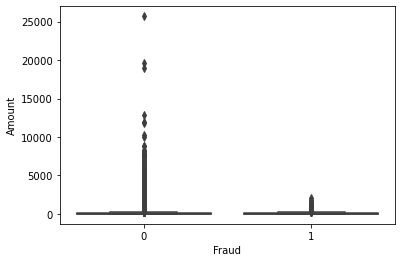

In [117]:
sns.boxplot(data=df, x="Fraud", y="Amount")

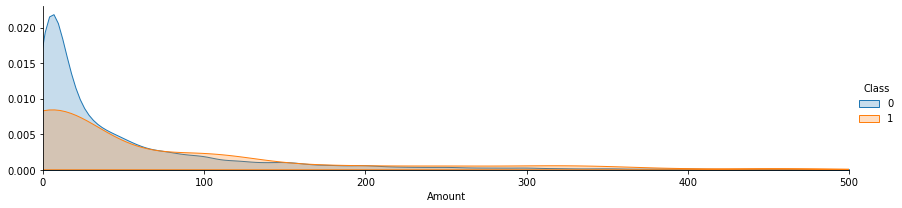

In [77]:
# distribution of time vs 'Exited'
facet = sns.FacetGrid(df[df.Amount<500],hue="Fraud",aspect = 4)
facet.map(sns.kdeplot,"Amount",shade = True)
facet.set(xlim = (0,500))
facet.add_legend()

# Random under sampling

In [180]:
regular_df=df[df.Fraud==0].sample(frac=1)
fraud_df=df[df.Fraud==1]
new_df=pd.concat([regular_df[:len(fraud_df)],fraud_df])

In [140]:
new_df.Fraud.value_counts()

1    492
0    492
Name: Fraud, dtype: int64

<AxesSubplot:>

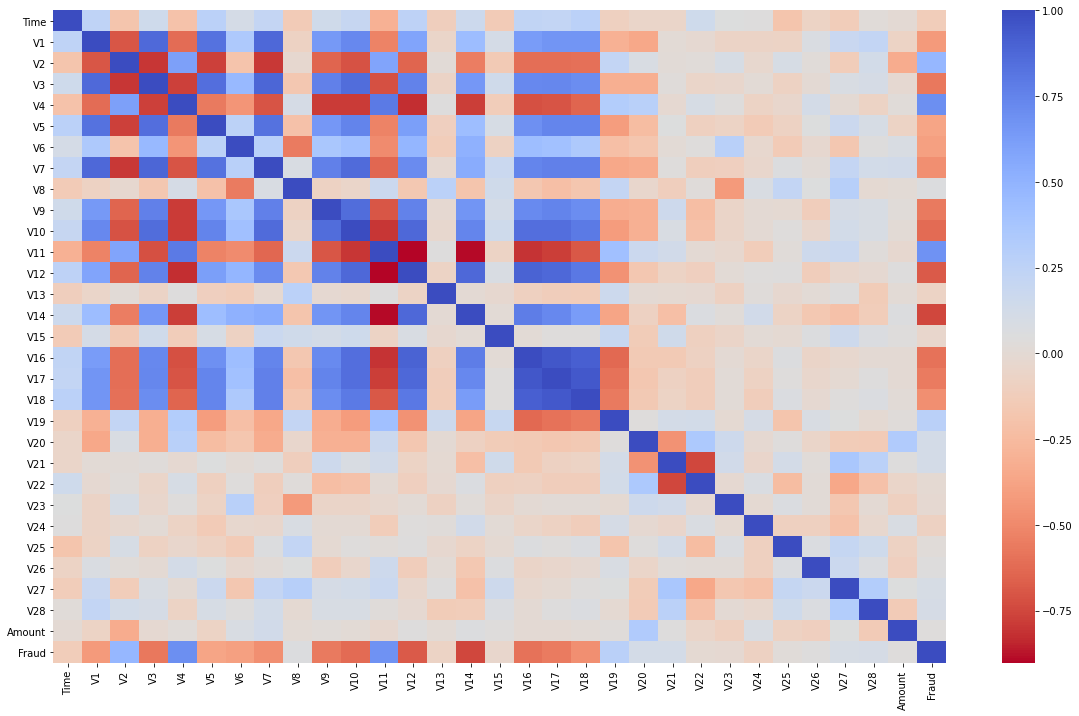

In [106]:
fig,ax=plt.subplots(figsize=(20,12))
sns.heatmap(new_df.corr(),cmap='coolwarm_r',annot_kws={'size':20},ax=ax)
# px.imshow(new_df.corr())

In [128]:
new_df.corr().Fraud.sort_values(ascending=False)

Fraud     1.000000
V4        0.701854
V11       0.687596
V2        0.472672
V19       0.275471
V21       0.122636
V20       0.120325
V28       0.103076
V27       0.098139
V8        0.058255
V26       0.047381
Amount    0.034387
V25       0.020915
V22      -0.003713
V23      -0.016138
V15      -0.032947
V13      -0.070976
V24      -0.089064
Time     -0.126963
V5       -0.371919
V6       -0.395825
V1       -0.425673
V18      -0.474803
V7       -0.476595
V17      -0.557918
V9       -0.563073
V3       -0.571118
V16      -0.596791
V10      -0.626221
V12      -0.679541
V14      -0.747118
Name: Fraud, dtype: float64

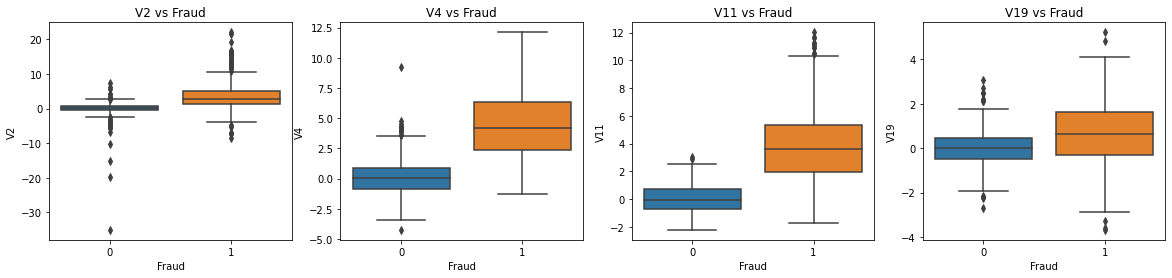

In [125]:
f, axes = plt.subplots(ncols=4,figsize=(20,4))

sns.boxplot(data=new_df,x="Fraud",y="V2",ax=axes[0])
axes[0].set_title("V2 vs Fraud")

sns.boxplot(data=new_df,x="Fraud",y="V4",ax=axes[1])
axes[1].set_title("V4 vs Fraud")

sns.boxplot(data=new_df,x="Fraud",y="V11",ax=axes[2])
axes[2].set_title("V11 vs Fraud")

sns.boxplot(data=new_df,x="Fraud",y="V19",ax=axes[3])
axes[3].set_title("V19 vs Fraud")

plt.show();

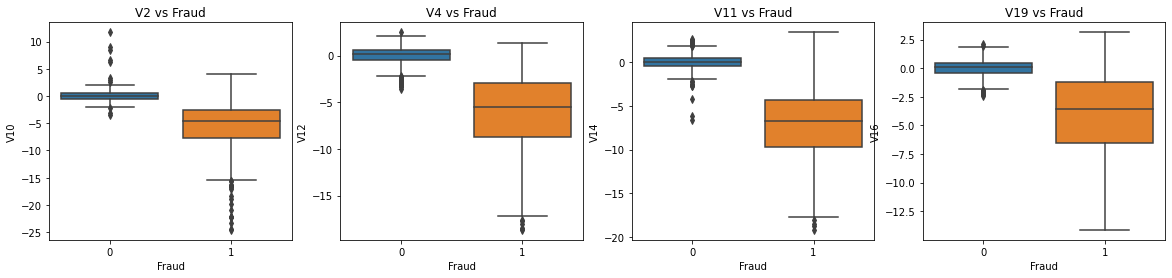

In [129]:
f, axes = plt.subplots(ncols=4,figsize=(20,4))

sns.boxplot(data=new_df,x="Fraud",y="V10",ax=axes[0])
axes[0].set_title("V2 vs Fraud")

sns.boxplot(data=new_df,x="Fraud",y="V12",ax=axes[1])
axes[1].set_title("V4 vs Fraud")

sns.boxplot(data=new_df,x="Fraud",y="V14",ax=axes[2])
axes[2].set_title("V11 vs Fraud")

sns.boxplot(data=new_df,x="Fraud",y="V16",ax=axes[3])
axes[3].set_title("V19 vs Fraud")

plt.show();

In [181]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler=StandardScaler()
new_df["Time"]=scaler.fit_transform(new_df[["Time"]])
new_df["Amount"]=scaler.fit_transform(new_df[["Amount"]])

<AxesSubplot:>

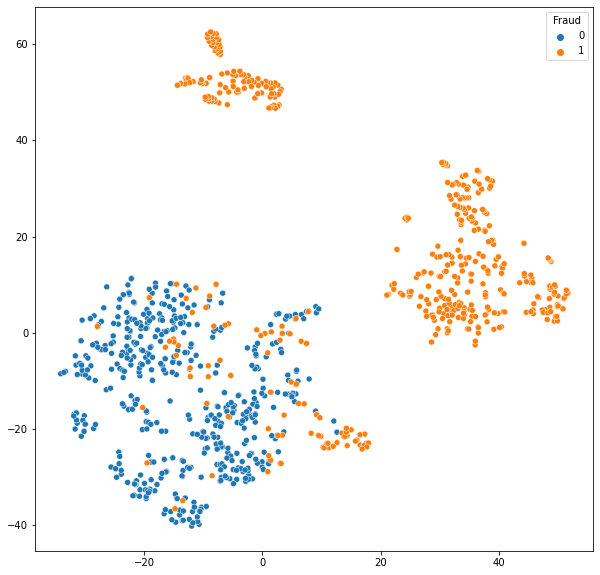

In [203]:
from sklearn.manifold import TSNE
model=TSNE()
X_tsne=model.fit_transform(new_df.iloc[:,:-1])

plt.subplots(figsize=(10,10))
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],hue=new_df.Fraud)

In [223]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
183114,0.458074,0.892607,1.048684,-4.250060,-0.882968,3.536460,2.946940,-0.634816,-2.034304,-0.572836,...,0.520931,-1.317137,0.279632,-0.010017,0.509272,0.663096,0.663956,-0.027175,0.145347,-0.195876
245712,0.758750,-1.228099,0.467901,0.853836,-0.735671,0.290881,0.386794,-0.042670,0.718085,-0.346274,...,0.280401,0.327244,0.708602,-0.150144,0.243609,0.061788,0.369482,0.198353,0.066464,0.448116
127437,-0.064893,1.167122,0.109903,0.492430,0.461680,-0.275135,-0.205385,-0.142045,0.102682,-0.156327,...,-0.132953,-0.180798,-0.553507,0.155101,0.001580,0.099521,0.107949,-0.019763,0.005151,-0.148829
8843,-0.796771,1.120380,-0.248450,0.737945,0.525663,-0.933417,-0.887130,-0.205883,-0.246435,2.049248,...,-0.020783,-0.207311,-0.248830,-0.061171,0.752626,0.350594,1.046742,-0.105529,0.007477,0.494959
142741,0.007779,1.032352,-0.039571,0.449114,1.368798,-0.329629,0.007754,-0.053254,0.169804,0.179838,...,-0.178821,-0.026006,-0.015811,-0.070425,0.203998,0.554131,-0.342693,0.021962,0.012117,0.272658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,0.938513,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,3.767872
280143,0.940778,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.195876
280149,0.940822,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,0.589562
281144,0.947618,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,2.291293


In [217]:
from sklearn.model_selection import train_test_split
X=new_df.iloc[:,:-1]
y=new_df.iloc[:,-1]
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.2)

In [233]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [236]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [262]:
for classifier in classifiers:
    print(classifier + " : " +str(cross_val_score(classifiers.get(classifier),X_train,y_train).mean()))

LogisiticRegression : 0.9351850358784166
KNearest : 0.9415705877610255
Support Vector Classifier : 0.9339434007901314
DecisionTreeClassifier : 0.9046843505603483


In [291]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
parameters = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



model = GridSearchCV(LogisticRegression(), parameters)
model.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
tuned_lr = model.best_estimator_

parameters = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(X_train, y_train)
# KNears best estimator
tuned_knn = model.best_estimator_

# Support Vector Classifier
parameters = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
model = GridSearchCV(SVC(), parameters)
model.fit(X_train, y_train)

# SVC best estimator
tuned_svc = model.best_estimator_

# DecisionTree Classifier
parameters = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
model = GridSearchCV(DecisionTreeClassifier(), parameters)
model.fit(X_train, y_train)

# tree best estimator
tuned_tree = model.best_estimator_

In [292]:
lr_score = cross_val_score(log_reg, X_train, y_train)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knn_score = cross_val_score(knears_neighbors, X_train, y_train)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.03%
Knears Neighbors Cross Validation Score 94.03%
Support Vector Classifier Cross Validation Score 93.77%
DecisionTree Classifier Cross Validation Score 91.87%


In [311]:
tuned_classifiers=[tuned_lr,tuned_knn,tuned_svc,tuned_tree]
for tuned_classifier in tuned_classifiers:
    print(tuned_classifier)
    print(classification_report(y_test,tuned_classifier.predict(X_test)))
    print(confusion_matrix(y_test,tuned_classifier.predict(X_test)))
    print("\n\n")

LogisticRegression(C=0.1)
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        90
           1       0.97      0.90      0.93       107

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

[[87  3]
 [11 96]]



KNeighborsClassifier(n_neighbors=2)
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        90
           1       0.98      0.87      0.92       107

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197

[[88  2]
 [14 93]]



SVC(C=0.7, kernel='linear')
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        90
           1       0.98      0.90      0.94       107

    accuracy                           0.93     

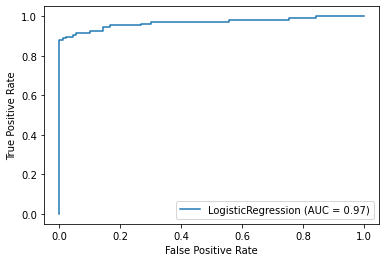

In [313]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(tuned_lr,X_test,y_test)